# разные модели в sklearn

In [1]:
import pandas as pd
import numpy as np
%pylab inline
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
pd.set_option('display.max_columns', None) # pd.options.display.max_columns = None 
# pd.set_option('display.max_rows', None) # не прятать столбцы при выводе дата-фреймов
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

from mlxtend.plotting import plot_decision_regions

Populating the interactive namespace from numpy and matplotlib


,0,1
0,1.162435,-0.061176
1,0.945128,-0.043227
2,1.078331,-0.102277
3,1.156040,0.115038
4,0.999199,0.228718


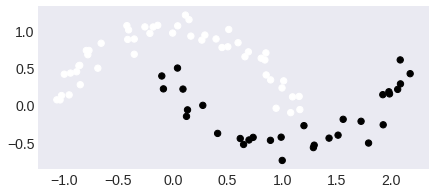

In [2]:
from sklearn.datasets import make_moons

n_samples=100

X, y = make_moons(n_samples=n_samples, shuffle=False, noise=0.1, random_state=1)

# прореживаем, чтобы был дисбаланс
i = (y==0) | (np.random.rand(n_samples) > 0.5)
X = X[i, :]
y = y[i]

plt.figure(figsize=(7, 3))
plt.scatter(X[:,0], X[:,1], 40, y)
pd.DataFrame(X[:5,:])

## SGDClassifier

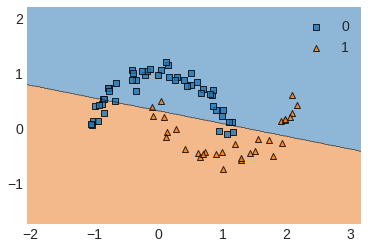

In [4]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X, y)
plot_decision_regions(X, y, sgd)

## Linear SVM

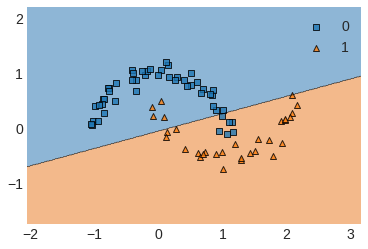

In [5]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X, y)
plot_decision_regions(X, y, svm)


## LDA

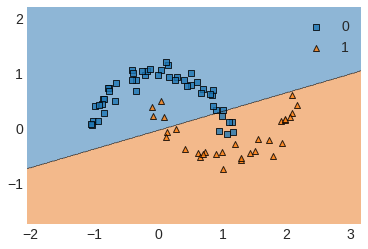

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(X, y)
plot_decision_regions(X, y, lda)

## SVM

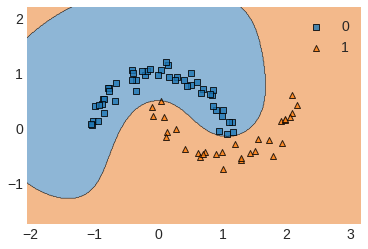

In [8]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', gamma=1.0)
svm.fit(X, y)
plot_decision_regions(X, y, svm)

## своя модель с нелинейностями

In [30]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression

class myC(BaseEstimator, ClassifierMixin):  
    """пример классификатора"""

    def __init__(self, n_estimators=10):
        """
        Инициализация
        """
        self.model = LogisticRegression(C=1)
    @staticmethod
    def addX(X):
        """
        Добавить 'случайные нелинейности'
        """
        XX = np.hstack([X,
                        (np.abs(X.dot([0.5, 0.5])) ** 0.5)[:, np.newaxis],
                        (np.abs(X.dot([0.25, 0.75])) ** 0.75)[:, np.newaxis],
                        (np.abs(X.dot([0.75, 0.25])) ** 1.5)[:, np.newaxis],
                        ])
        return (XX)
        


    def fit(self, X, y=None):
        """
        Обучение
        """
        self.model.fit(self.addX(X), y)

        return self


    def predict(self, X, y=None):
        """
        классификация
        """
        
        return(self.model.predict(self.addX(X)))

    def predict_proba(self, X, y=None):
        """
        вероятность
        """
        
        return(self.model.predict_proba(self.addX(X)))

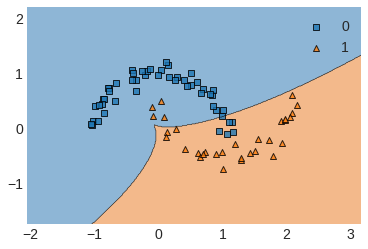

In [31]:
myc = myC()
myc.fit(X, y)
plot_decision_regions(X, y, myc)

In [56]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

class myC(BaseEstimator, ClassifierMixin):  
    """пример классификатора"""

    def __init__(self, alpha=1.0, k=5):
        """
        Инициализация
        """
        self.model = LogisticRegression(C=1)
        self.cluster = KMeans(n_clusters=k)
        self.alpha = alpha
    
    @staticmethod
    def addX(self, X):
        """
        Добавить 'случайные нелинейности'
        """
        XX = X.copy()
        for x in self.cluster.cluster_centers_:
            XX = np.hstack([XX,
                            np.exp(-self.alpha*((X - x) ** 2).sum(axis=1, keepdims=True))])
        return (XX)
        


    def fit(self, X, y=None):
        """
        Обучение
        """
        self.cluster.fit(X)
        self.model.fit(self.addX(self, X), y)

        return self


    def predict(self, X, y=None):
        """
        классификация
        """
        
        return(self.model.predict(self.addX(self, X)))

    def predict_proba(self, X, y=None):
        """
        вероятность
        """
        
        return(self.model.predict_proba(self.addX(self, X)))

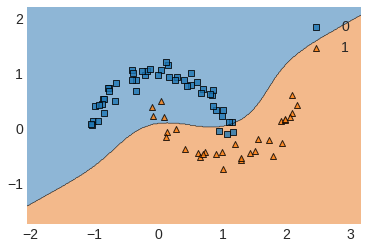

In [61]:
myc = myC(alpha=1.01, k=10)
myc.fit(X, y)
plot_decision_regions(X, y, myc)

# деревья

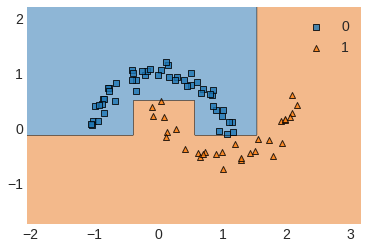

In [62]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X, y)
plot_decision_regions(X, y, tree)

# голосование

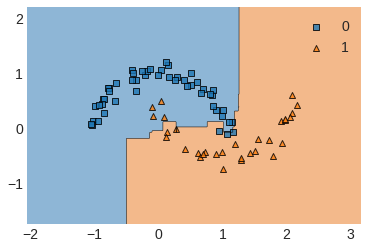

In [77]:
from sklearn.ensemble import VotingClassifier

estimators = [(str(i), DecisionTreeClassifier(max_depth=3, splitter='random', random_state=i)) for i in range(9)]

vc = VotingClassifier(estimators, voting ="soft")
vc.fit(X, y)
plot_decision_regions(X, y, vc)

# бэггинг

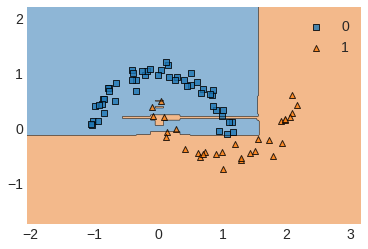

In [64]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                        n_estimators=10,
                        random_state=0).fit(X, y)
clf.fit(X, y)
plot_decision_regions(X, y, clf)

# AdaBoost

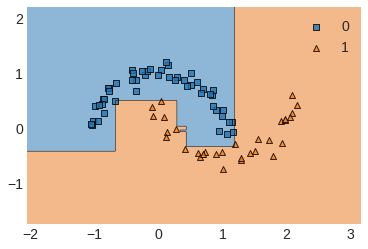

In [67]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                         n_estimators=100, random_state=0)
ada.fit(X, y)
plot_decision_regions(X, y, ada)

# стекинг

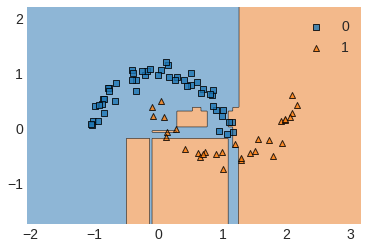

In [76]:
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.tree import DecisionTreeRegressor

estimators = [(str(i), DecisionTreeClassifier(max_depth=3, splitter='random', random_state=i)) for i in range(9)]
# не работает! estimators = [(str(i), DecisionTreeRegressor(max_depth=3, splitter='random', random_state=i)) for i in range(9)]

stack = StackingClassifier(estimators,
                           final_estimator=LogisticRegression(C=1.0))
stack.fit(X, y)
plot_decision_regions(X, y, stack)

